In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


In [67]:
#read into the main body of data (there are three files to read)
#jobs implies the 'jobs' the request of which has been sent to the servers at ACCRE
jobs = pd.read_csv('../data/accre.csv')
jobs.head(2)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,TIMEOUT,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:15


In [68]:
#turn the BEGIN and END columns data type into datetime
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce') #coerce turns the unknown data types into nulls
jobs['END'] = pd.to_datetime(jobs['END'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [69]:
#save the jobs with null BEGIN/END in separate CSVs, for later use (maybe)
jobs_null_begin = jobs[jobs['BEGIN'].isnull()].reset_index(drop = True)
jobs_null_begin = jobs_null_begin.to_csv('Jobs-with-null-begin', index = False)

jobs_null_end = jobs[jobs['END'].isnull()].reset_index(drop = True)
jobs_null_end = jobs_null_end.to_csv('Jobs-with-null-end', index = False)


In [70]:
#since I have already worked on 'jobs', I keep its name as it is
# delimit jobs to where BEGIN/END is not null (following the instructions)
jobs = jobs[jobs['BEGIN'].notnull() & jobs['END'].notnull()].reset_index(drop = True)
jobs.head(2)


,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30853133,TIMEOUT,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:15
1,30858137,TIMEOUT,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:15


In [71]:
#break the begin/end times into separate columns
jobs['end_date'] = jobs['END'].dt.date
jobs['end_year'] = jobs['END'].dt.year
jobs['end_month'] = jobs['END'].dt.month
jobs['end_week'] = jobs['END'].dt.week
jobs['end_hour'] = jobs['END'].dt.hour
jobs['end_weekday'] = jobs['END'].dt.weekday


/var/folders/cl/6732l4td4930rpqrp4rpmpt80000gn/T/ipykernel_67971/2923000964.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  jobs['end_week'] = jobs['END'].dt.week


In [72]:
pd.options.display.max_columns = 50

In [73]:
#change column names to lower case based on the instructions
jobs = jobs.rename(columns=str.lower)
jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday
0,30853133,TIMEOUT,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:15,2021-09-05,2021,9,35,11,6
1,30858137,TIMEOUT,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:15,2021-09-05,2021,9,35,19,6


In [74]:
jobs['state'].value_counts()

COMPLETED              5871385
FAILED                 1095351
TIMEOUT                 170748
CANCELLED by 9201        43033
PREEMPTED                24563
                        ...   
CANCELLED by 763919          1
CANCELLED by 760934          1
CANCELLED by 851113          1
CANCELLED by 789845          1
CANCELLED by 421502          1
Name: state, Length: 543, dtype: int64

In [75]:
jobs['exitcode'].value_counts()

0:0      5885191
1:0       782434
0:15      295717
127:0     166616
0:9       106609
          ...   
76:0           1
43:0           1
46:0           1
54:0           1
19:0           1
Name: exitcode, Length: 72, dtype: int64

In [76]:
jobs['partition'].value_counts()

production              7019136
nogpfs                   147044
pascal                   124451
sam                       64967
turing                    21412
maxwell                   11278
cgw-maizie                 4308
debug                      1616
cgw-platypus                376
cgw-dsi-gw                  228
cgw-capra1                  153
cgw-dougherty1              125
cgw-horus                    61
cgw-cqs1                     28
cgw-hanuman                  21
cgw-sideshowbob              14
cgw-vm-qa-flatearth1          9
cgw-tbi01                     7
Name: partition, dtype: int64

In [77]:
#make a new data frame with the jobs ended
jobs_ended = jobs[['end_date', 'end_year', 'end_month', 'end_week', 'end_hour']].reset_index(drop = True)
jobs_ended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395234 entries, 0 to 7395233
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   end_date   object
 1   end_year   int64 
 2   end_month  int64 
 3   end_week   int64 
 4   end_hour   int64 
dtypes: int64(4), object(1)
memory usage: 282.1+ MB


In [78]:
#delimit to the jobs that are completed in state
jobs_completed = jobs[jobs['state'] == 'COMPLETED']
jobs_completed.info()
#the jobs having an end date, are those that have 'complete status': same count

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5871385 entries, 4 to 7395233
Data columns (total 18 columns):
 #   Column       Dtype         
---  ------       -----         
 0   jobid        object        
 1   state        object        
 2   begin        datetime64[ns]
 3   end          datetime64[ns]
 4   reqmem       object        
 5   usedmem      object        
 6   reqtime      object        
 7   usedtime     object        
 8   nodes        int64         
 9   cpus         int64         
 10  partition    object        
 11  exitcode     object        
 12  end_date     object        
 13  end_year     int64         
 14  end_month    int64         
 15  end_week     int64         
 16  end_hour     int64         
 17  end_weekday  int64         
dtypes: datetime64[ns](2), int64(7), object(9)
memory usage: 851.1+ MB


In [79]:
# roll the jobs per hour but sort the values of the column first
#make sure the column in in datetime format
jobs = jobs.sort_values('end').reset_index(drop = True)
jobs['end_date'] = pd.to_datetime(jobs['end_date'])
jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0,2020-10-01,2020,10,40,0,3
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0,2020-10-01,2020,10,40,0,3


In [80]:
jobs[['end_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395234 entries, 0 to 7395233
Data columns (total 1 columns):
 #   Column    Dtype         
---  ------    -----         
 0   end_date  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 56.4 MB


In [81]:
jobs['end_per_hour'] = jobs.rolling('1h', on = 'end_date')['jobid'].count()
jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday,end_per_hour
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0,2020-10-01,2020,10,40,0,3,1.0
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0,2020-10-01,2020,10,40,0,3,2.0


In [82]:
#create new column: job length
jobs['job_length'] = jobs['end'] - jobs['begin']
jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday,end_per_hour,job_length
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0,2020-10-01,2020,10,40,0,3,1.0,0 days 00:04:20
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0,2020-10-01,2020,10,40,0,3,2.0,0 days 00:02:20


In [83]:
jobs['reqmem'].value_counts()

2048Mn      1180859
4096Mn       906233
2048Mc       545202
16384Mn      428857
1024Mn       365092
             ...   
12415Mn           1
11490Mn           1
5951Mn            1
9315Mn            1
972800Mn          1
Name: reqmem, Length: 358, dtype: int64

In [84]:
#calculate the required memory for all nodes per job
jobs['reqmem_all_nodes'] = jobs['reqmem'].str.extract('(\d+)Mn')
jobs['reqmem_all_nodes'] = pd.to_numeric(jobs['reqmem_all_nodes'], errors = 'coerce') #.astype gave an error for Nans, but this method worked
jobs['reqmem_all_nodes'] = jobs['reqmem_all_nodes'] * jobs['nodes']
jobs[jobs['nodes'] == 2].reset_index() #to check if the multiplication has worked


,index,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday,end_per_hour,job_length,reqmem_all_nodes
0,104741,24607646_1,FAILED,2020-10-05 09:59:31,2020-10-05 09:59:43,6144Mn,0,15:00:00,00:00:12,2,2,production,1:0,2020-10-05,2020,10,41,9,0,8137.0,0 days 00:00:12,12288.0
1,109192,24615543,COMPLETED,2020-10-05 14:45:12,2020-10-05 15:39:36,122880Mn,9712.86M,20:00:00,00:54:24,2,1,pascal,0:0,2020-10-05,2020,10,41,15,0,12588.0,0 days 00:54:24,245760.0
2,113620,24611991_15,COMPLETED,2020-10-05 12:29:32,2020-10-05 18:44:24,6144Mn,2113.78M,15:00:00,06:14:52,2,2,production,0:0,2020-10-05,2020,10,41,18,0,17016.0,0 days 06:14:52,12288.0
3,114318,24611991_66,COMPLETED,2020-10-05 12:29:32,2020-10-05 19:15:32,6144Mn,2072.97M,15:00:00,06:46:00,2,2,production,0:0,2020-10-05,2020,10,41,19,0,17714.0,0 days 06:46:00,12288.0
4,114609,24611991_65,COMPLETED,2020-10-05 12:29:32,2020-10-05 19:33:06,6144Mn,2110.86M,15:00:00,07:03:34,2,2,production,0:0,2020-10-05,2020,10,41,19,0,18005.0,0 days 07:03:34,12288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,7348320,32862570,FAILED,2021-09-29 14:15:03,2021-09-29 14:16:10,51200Mn,131.07M,20:00:00,00:01:07,2,8,production,1:0,2021-09-29,2021,9,39,14,2,6071.0,0 days 00:01:07,102400.0
3521,7348339,32862613,FAILED,2021-09-29 14:19:16,2021-09-29 14:19:31,51200Mn,0,20:00:00,00:00:15,2,8,production,1:0,2021-09-29,2021,9,39,14,2,6090.0,0 days 00:00:15,102400.0
3522,7350405,32862697,COMPLETED,2021-09-29 14:27:43,2021-09-29 18:06:22,51200Mn,36268.61M,20:00:00,03:38:39,2,8,production,0:0,2021-09-29,2021,9,39,18,2,8156.0,0 days 03:38:39,102400.0
3523,7392356,32913244,COMPLETED,2021-10-03 13:19:09,2021-10-03 13:20:58,92160Mn,0,3-18:00:00,00:01:49,2,10,maxwell,0:0,2021-10-03,2021,10,39,13,6,1036.0,0 days 00:01:49,184320.0


In [85]:
#calculate the required memory for all CPUs per job
jobs['reqmem_all_cpus'] = jobs['reqmem'].str.extract('(\d+)Mc')
jobs['reqmem_all_cpus'] = pd.to_numeric(jobs['reqmem_all_cpus'], errors = 'coerce')
jobs['reqmem_all_cpus'] = jobs['reqmem_all_cpus'] * jobs['cpus']

In [86]:
#failed jobs are those whose exist code is other than 0:0
#instead of quory, we can use slicing using brackets, too.
failed_jobs = jobs.query('exitcode != "0:0"').reset_index(drop = True)
failed_jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday,end_per_hour,job_length,reqmem_all_nodes,reqmem_all_cpus
0,24460671,FAILED,2020-10-01 00:17:08,2020-10-01 00:17:53,1024Mc,636.96M,00:30:00,00:00:45,1,1,production,0:9,2020-10-01,2020,10,40,0,3,5.0,0 days 00:00:45,NaN,1024.0
1,24460555,FAILED,2020-10-01 00:03:08,2020-10-01 00:23:13,1024Mc,6.23M,00:30:00,00:20:05,1,4,production,1:0,2020-10-01,2020,10,40,0,3,7.0,0 days 00:20:05,NaN,4096.0


In [87]:
#how are existcodes related to partitions
failed_jobs.groupby(['exitcode', 'partition'])['partition'].count()

exitcode  partition 
0:105     production      2
0:11      nogpfs          2
          production     35
0:12      production      1
0:125     cgw-maizie      4
                       ... 
99:0      production      3
9:0       cgw-maizie      2
          maxwell         3
          pascal         68
          production    355
Name: partition, Length: 179, dtype: int64

In [23]:
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log', sep=" - ", header=None)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [24]:
ce5.head(2)

,0,1,2,3,4,5
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [25]:
#change column names
ce5 = ce5.rename(columns = {0:'date/time', 1:'user', 2:'retry', 3: 'laps', 4: 'returncode', 5: 'command'})
ce5.head(2)

,date/time,user,retry,laps,returncode,command
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [26]:
#clean the columns
ce5['command'] = ce5['command'].str.extract('\[\'\/usr\/bin\/([a-zA-Z]*)')
ce5.head(2)

,date/time,user,retry,laps,returncode,command
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,sacct
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,sacct


In [27]:
ce5['user'].str.slice(start = 5)
ce5['retry'] = ce5['retry'].str.slice(start = 6)
ce5['laps'] = ce5['laps'].str.slice(start = 5)
ce5['returncode'] = ce5['returncode'].str.slice(start = 11)
ce5.head(2)

,date/time,user,retry,laps,returncode,command
0,2020-10-16 08:15:39.278699,user 0,0,0.07347559928894043,0,sacct
1,2020-10-16 08:18:08.313309,user 0,0,0.18363237380981445,0,sacct


In [28]:
ce5.to_csv('ce5', index = False) #ignore previous indices

In [29]:
#read through the third data set
ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log', sep=" - ", header=None)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [30]:
#clean the third data set in the same way as the second data set
ce6 = ce6.rename(columns = {0:'date/time', 1:'user', 2:'retry', 3: 'laps', 4: 'returncode', 5: 'command'})
ce6['command'] = ce6['command'].str.extract('\[\'\/usr\/bin\/([a-zA-Z]*)')
ce6['user'].str.slice(start = 5)
ce6['retry'] = ce6['retry'].str.slice(start = 6)
ce6['laps'] = ce6['laps'].str.slice(start = 5)
ce6['returncode'] = ce6['returncode'].str.slice(start = 11)

In [31]:
#read ce6 into a new df
ce6.to_csv('ce6', index = False)

In [32]:
#before concatenation, specify where the rows are coming from
ce5['server'] = 'ce5'
ce6['server'] = 'ce6'

In [33]:
#concatinate the two DFs
ce5_ce6 = pd.concat([ce5, ce6]).reset_index(drop = True) #get rid of old indices
ce5_ce6.head(2)


,date/time,user,retry,laps,returncode,command,server
0,2020-10-16 08:15:39.278699,user 0,0,0.07347559928894043,0,sacct,ce5
1,2020-10-16 08:18:08.313309,user 0,0,0.18363237380981445,0,sacct,ce5


In [34]:
#.astype(float) gave an error, but this did not:
ce5_ce6['laps'] = pd.to_numeric(ce5_ce6['laps'],errors='coerce') # coerce will replace all non-numeric values with NaN

In [35]:
#sort the date/time column and change the type of datetime
ce5_ce6.sort_values('date/time', ascending = True)
ce5_ce6['date/time'] = pd.to_datetime(ce5_ce6['date/time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce') 
ce5_ce6['date'] = ce5_ce6['date/time'].dt.date
ce5_ce6['year'] = ce5_ce6['date/time'].dt.year
ce5_ce6['month'] = ce5_ce6['date/time'].dt.month
ce5_ce6['week'] = ce5_ce6['date/time'].dt.week
ce5_ce6['hour'] = ce5_ce6['date/time'].dt.hour
ce5_ce6['weekday'] = ce5_ce6['date/time'].dt.weekday


/var/folders/cl/6732l4td4930rpqrp4rpmpt80000gn/T/ipykernel_67971/4176402905.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  ce5_ce6['week'] = ce5_ce6['date/time'].dt.week


In [36]:
ce5_ce6.head(2)

,date/time,user,retry,laps,returncode,command,server,date,year,month,week,hour,weekday
0,2020-10-16 08:15:39.278699,user 0,0,0.073476,0,sacct,ce5,2020-10-16,2020,10,42,8,4
1,2020-10-16 08:18:08.313309,user 0,0,0.183632,0,sacct,ce5,2020-10-16,2020,10,42,8,4


In [37]:
#Looking for specific settings (time out jobs)
time_out = ce5_ce6[(ce5_ce6['user'] == 'user 9204') &
 (ce5_ce6['returncode'] == '1') &
   (ce5_ce6['laps'] > 15) &
    (ce5_ce6['command'] == 'sbatch')]

In [38]:
time_out.reset_index(drop = True)
time_out.head(2)

,date/time,user,retry,laps,returncode,command,server,date,year,month,week,hour,weekday
49958,2020-10-18 06:53:44.272915,user 9204,0,20.038464,1,sbatch,ce5,2020-10-18,2020,10,42,6,6
49972,2020-10-18 06:54:04.322412,user 9204,1,20.048906,1,sbatch,ce5,2020-10-18,2020,10,42,6,6


In [39]:
time_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3296 entries, 49958 to 9537761
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date/time   3296 non-null   datetime64[ns]
 1   user        3296 non-null   object        
 2   retry       3296 non-null   object        
 3   laps        3296 non-null   float64       
 4   returncode  3296 non-null   object        
 5   command     3296 non-null   object        
 6   server      3296 non-null   object        
 7   date        3296 non-null   object        
 8   year        3296 non-null   int64         
 9   month       3296 non-null   int64         
 10  week        3296 non-null   int64         
 11  hour        3296 non-null   int64         
 12  weekday     3296 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 360.5+ KB


In [40]:
time_out['user'] = time_out['user'].str.slice(start = 5)

/var/folders/cl/6732l4td4930rpqrp4rpmpt80000gn/T/ipykernel_67971/4275537433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_out['user'] = time_out['user'].str.slice(start = 5)


In [41]:
time_out.reset_index(drop = True).head(2)

,date/time,user,retry,laps,returncode,command,server,date,year,month,week,hour,weekday
0,2020-10-18 06:53:44.272915,9204,0,20.038464,1,sbatch,ce5,2020-10-18,2020,10,42,6,6
1,2020-10-18 06:54:04.322412,9204,1,20.048906,1,sbatch,ce5,2020-10-18,2020,10,42,6,6


In [42]:
#before rolling, always sort
time_out = time_out.sort_values('date/time')

In [43]:
#create new column by rolling (rolling produces average values: per hour,in average/mean)
time_out['time_out_per_week'] = time_out.rolling('7d', on = 'date/time')['user'].count()

In [44]:
#create new column by rolling
time_out['time_out_per_hour'] = time_out.rolling('1h', on = 'date/time')['user'].count()

In [45]:
failed_jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday,end_per_hour,job_length,reqmem_all_nodes,reqmem_all_cpus
0,24460671,FAILED,2020-10-01 00:17:08,2020-10-01 00:17:53,1024Mc,636.96M,00:30:00,00:00:45,1,1,production,0:9,2020-10-01,2020,10,40,0,3,5.0,0 days 00:00:45,NaN,1024.0
1,24460555,FAILED,2020-10-01 00:03:08,2020-10-01 00:23:13,1024Mc,6.23M,00:30:00,00:20:05,1,4,production,1:0,2020-10-01,2020,10,40,0,3,7.0,0 days 00:20:05,NaN,4096.0


<AxesSubplot:xlabel='year'>

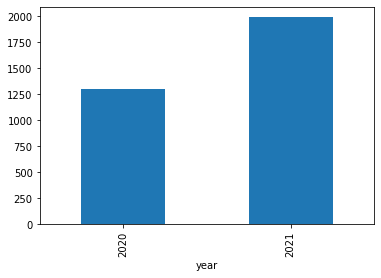

In [46]:
time_out.groupby('year')['user'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='month'>

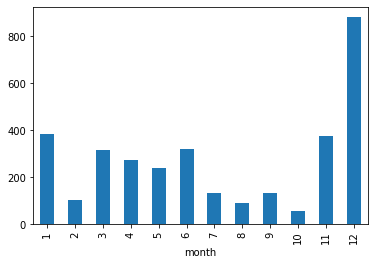

In [47]:
time_out.groupby('month')['user'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='weekday'>

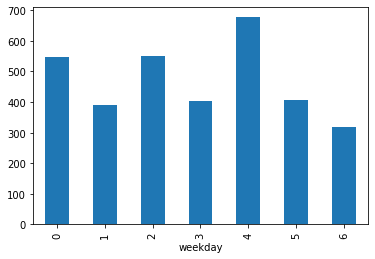

In [48]:
time_out.groupby('weekday')['user'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='end_year'>

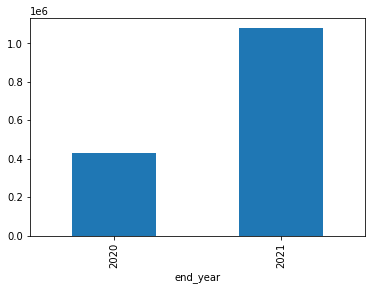

In [49]:
failed_jobs.groupby('end_year')['jobid'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='end_month'>

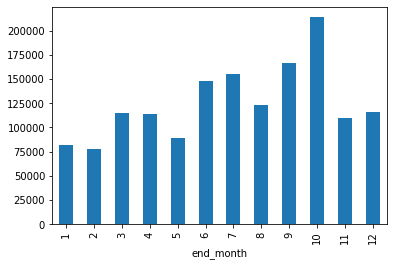

In [50]:
failed_jobs.groupby('end_month')['jobid'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='end_weekday'>

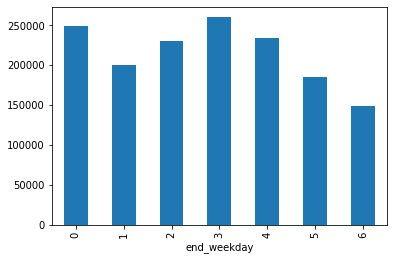

In [51]:
failed_jobs.groupby('end_weekday')['jobid'].count().plot(kind = 'bar')

In [52]:
jobs.groupby('partition')['job_length'].mean().sort_values(ascending = False)

partition
cgw-tbi01              10 days 10:22:21.857142857
cgw-dougherty1             6 days 16:56:31.968000
cgw-capra1              4 days 23:58:03.483660130
cgw-sideshowbob         4 days 07:38:43.214285714
cgw-cqs1                3 days 13:30:28.678571428
cgw-platypus            1 days 13:58:25.664893617
cgw-hanuman             0 days 18:30:55.666666666
cgw-vm-qa-flatearth1    0 days 18:16:16.888888888
cgw-dsi-gw              0 days 13:11:31.552631578
maxwell                 0 days 12:34:33.142489803
nogpfs                  0 days 11:52:57.914460977
cgw-horus               0 days 06:12:30.704918032
production              0 days 03:40:09.351169289
pascal                  0 days 02:44:29.079372604
turing                  0 days 02:33:30.761488884
cgw-maizie              0 days 00:57:35.821262766
debug                   0 days 00:28:16.545173267
sam                     0 days 00:02:25.129558083
Name: job_length, dtype: timedelta64[ns]

In [53]:
#roll for failed jobs
failed_jobs = failed_jobs.sort_values('end')
failed_jobs['failed_per_week'] = failed_jobs.rolling('7d', on = 'end')['jobid'].count()
failed_jobs['failed_per_hour'] = failed_jobs.rolling('1h', on = 'end')['jobid'].count()




In [54]:

time_out.to_csv('../data/time_out.csv', index = False)


In [55]:
time_out.describe()

,laps,year,month,week,hour,weekday,time_out_per_week,time_out_per_hour
count,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000
mean,20.361547,2020.603762,7.221784,30.778216,13.036104,2.838592,149.728459,4.503034
std,2.352944,0.489189,4.049649,17.741756,6.518486,1.918058,141.356996,4.156643
min,19.025584,2020.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,20.033297,2020.000000,4.000000,16.000000,9.000000,1.000000,48.000000,2.000000
50%,20.040104,2021.000000,7.000000,29.000000,14.000000,3.000000,99.000000,3.000000
75%,20.046859,2021.000000,12.000000,49.000000,18.000000,4.000000,211.000000,6.000000
max,43.078285,2021.000000,12.000000,53.000000,23.000000,6.000000,564.000000,26.000000


<AxesSubplot:xlabel='date/time'>

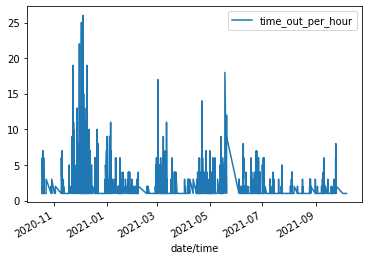

In [56]:
time_out.plot(x = 'date/time', y = 'time_out_per_hour')

<AxesSubplot:xlabel='date/time'>

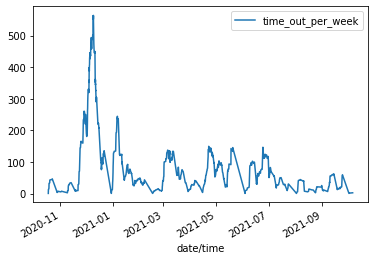

In [57]:
time_out.plot(x = 'date/time', y = 'time_out_per_week')

In [58]:
#Look into more details about partitions: 
partition_state = pd.crosstab(jobs['partition'], jobs['state'])
partition_state.head(5)


state,CANCELLED,CANCELLED by 0,CANCELLED by 103040,CANCELLED by 108679,CANCELLED by 111694,CANCELLED by 112870,CANCELLED by 116648,CANCELLED by 123431,CANCELLED by 124006,CANCELLED by 141603,CANCELLED by 153500,CANCELLED by 156658,CANCELLED by 157854,CANCELLED by 159541,CANCELLED by 160027,CANCELLED by 161909,CANCELLED by 164131,CANCELLED by 168618,CANCELLED by 169069,CANCELLED by 170568,CANCELLED by 171822,CANCELLED by 174423,CANCELLED by 175381,CANCELLED by 177470,CANCELLED by 195064,...,CANCELLED by 907426,CANCELLED by 908144,CANCELLED by 909530,CANCELLED by 9100,CANCELLED by 915792,CANCELLED by 918920,CANCELLED by 9201,CANCELLED by 9202,CANCELLED by 9203,CANCELLED by 9204,CANCELLED by 9206,CANCELLED by 9210,CANCELLED by 9211,CANCELLED by 9219,CANCELLED by 9221,CANCELLED by 93631,CANCELLED by 96504,COMPLETED,FAILED,NODE_FAIL,OUT_OF_MEMORY,PREEMPTED,REQUEUED,RUNNING,TIMEOUT
partition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cgw-capra1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,32,0,0,0,0,0,74
cgw-cqs1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,10,0,0,0,0,0,9
cgw-dougherty1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,86
cgw-dsi-gw,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,20,0,0,0,0,0,96
cgw-hanuman,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5


In [59]:
#only look into three specific states
partition_state_new = partition_state[['COMPLETED', 'FAILED', 'TIMEOUT']]
partition_state_new = partition_state_new.sort_values(by = 'COMPLETED', ascending = False)
partition_state_new = partition_state_new.head(5)
partition_state_new

state,COMPLETED,FAILED,TIMEOUT
partition,,,
production,5635155,986710,166545
pascal,87581,19409,1852
sam,64721,46,0
nogpfs,54397,84106,6
turing,17756,1505,944


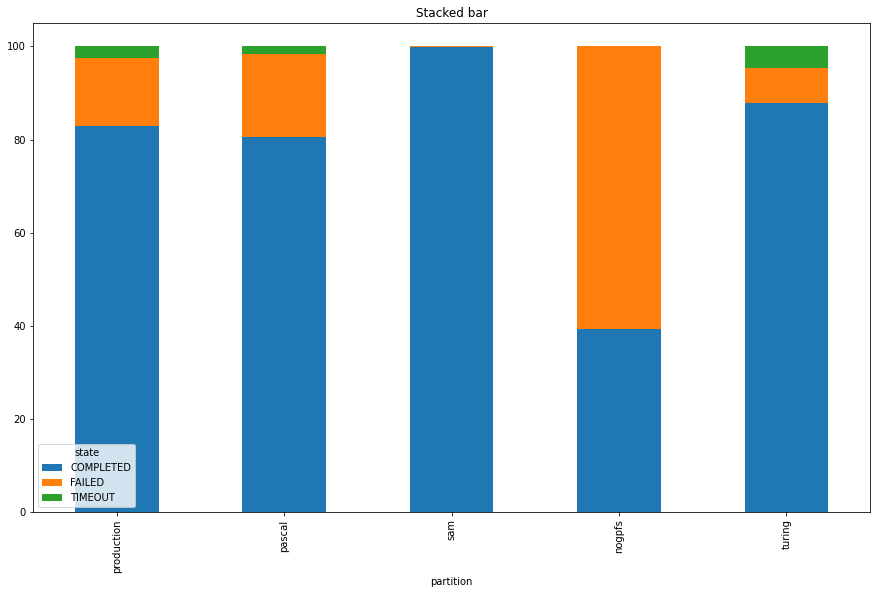

In [60]:
#completed, timed-out, and failed jobs per partition
dfg = partition_state_new
data = dfg.div(dfg.sum(axis=1), axis=0).mul(100)
data.plot(kind='bar', stacked=True, figsize=(15,9), title='Stacked bar')
plt.show()

In [61]:
jobs.head(2)

,jobid,state,begin,end,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,end_date,end_year,end_month,end_week,end_hour,end_weekday,end_per_hour,job_length,reqmem_all_nodes,reqmem_all_cpus
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0,2020-10-01,2020,10,40,0,3,1.0,0 days 00:04:20,NaN,4096.0
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0,2020-10-01,2020,10,40,0,3,2.0,0 days 00:02:20,2000.0,NaN


In [62]:
#before plotting, replace end_weekday numbers with strings showing the day of the week
jobs['end_weekday'].value_counts()

1    1300031
2    1182419
0    1120898
3    1033677
4    1027294
6     882823
5     848092
Name: end_weekday, dtype: int64

In [63]:
jobs['end_weekday'].replace({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",4:"Friday", 5: "Saturday", 6: "Sunday"}, inplace=True)

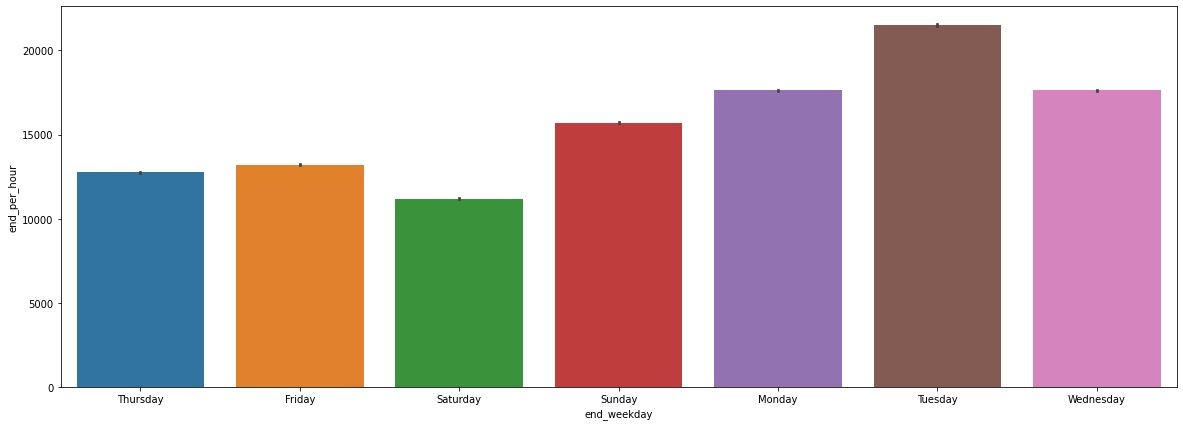

In [64]:
# ended jobs over the days of the week
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x = 'end_weekday', y = 'end_per_hour', data = jobs, ax = ax)
plt.show()

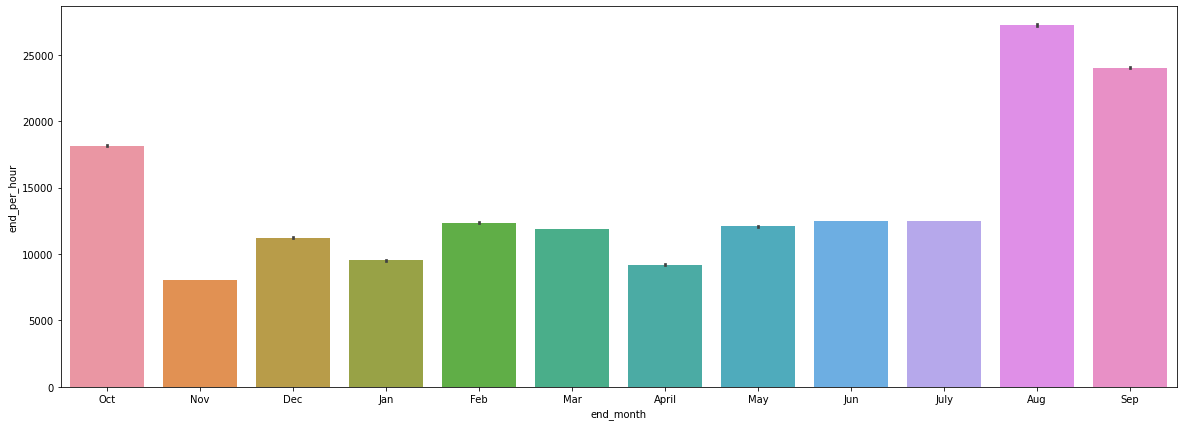

In [65]:
#completed jobs over the months
jobs['end_month'].replace({1: "Jan", 2: "Feb", 3: "Mar", 4: "April",5: "May", 6: "Jun", 7: "July", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}, inplace=True)
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x = 'end_month', y = 'end_per_hour', data = jobs, ax = ax)
plt.show()